In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch.distributions
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y = sample_data()

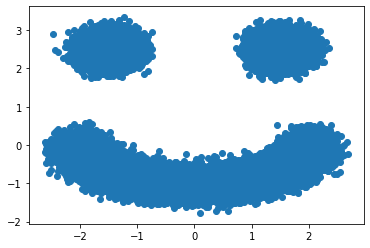

In [17]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [0]:
if not torch.cuda.is_available():
  print('kek')
device = torch.device('cuda')

In [0]:
def NLLLoss(x):
  return -torch.mean(torch.log(x)) / 2

In [0]:
class Flow2D(nn.Module):
  def __init__(self, k: int):
    super().__init__()
    self.k = k
    self.pi = nn.Parameter(torch.tensor(np.random.dirichlet(np.ones(k),size=1))).to(device)
    self.mu = nn.Parameter(torch.tensor(np.random.uniform(0, 1, k))).to(device)
    self.sigma = nn.Parameter(torch.tensor(np.random.uniform(0, 1, k))).to(device)
    self.pi_x1 = nn.Linear(1, k).to(device)
    self.mu_x1 = nn.Linear(1, k).to(device)
    self.sigma_x1 = nn.Linear(1, k).to(device)
    self.pi_softmax = nn.Softmax(dim=-1)
    self.pi_x1_softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x1, x2 = x[:,0], x[:,1]
    pi_x1 = self.pi_x1(x1.view(-1,1))
    pi_x1 = self.pi_x1_softmax(pi_x1)
    mu_x1 = self.mu_x1(x1.view(-1,1))
    sigma_x1 = self.sigma_x1(x1.view(-1,1))
    p = torch.zeros(x1.shape[0]).to(device)
    p_x1 = torch.zeros(x1.shape[0]).to(device)
    pi = self.pi_softmax(self.pi)
    for i in range(self.k):
      p += pi[0][i] * torch.distributions.Normal(self.mu[i], torch.exp(self.sigma[i])).log_prob(x1).exp()
      p_x1 += pi_x1[:,i] * torch.distributions.Normal(mu_x1[:,i], torch.exp(sigma_x1[:,i])).log_prob(x2).exp()
    return p * p_x1

In [0]:
batch_size = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_data = torch.utils.data.DataLoader(torch.from_numpy(X_train), batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(torch.from_numpy(X_test), batch_size=batch_size, shuffle=False)

In [0]:
model = Flow2D(10)
model = model.float()
model = model.to(device)
lr = 0.01
n_epoch = 50
opt = torch.optim.Adam(model.parameters(), lr)
loss_function = NLLLoss

In [260]:
train_loss = []
test_loss = []
for epoch in tqdm(range(n_epoch)):
  train_loss_epoch = []
  test_loss_epoch = []
  for data in train_data:
    data = data.float()
    data = data.to(device)
    opt.zero_grad()
    out = model(data)
    loss = loss_function(out)
    train_loss_epoch.append(loss.item())
    loss.backward()
    opt.step()
  with torch.no_grad():
    for test_batch in test_data:
      test_batch = test_batch.float()
      test_batch = test_batch.to(device)
      out = model(test_batch)
      loss = loss_function(out)
      test_loss_epoch.append(loss.item())
  test_loss.append(np.mean(test_loss_epoch))
  train_loss.append(np.mean(train_loss_epoch))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/dul_hw2_flow2d'
torch.save(model.state_dict(), PATH)

In [274]:
model2 = Flow2D(10)
model2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

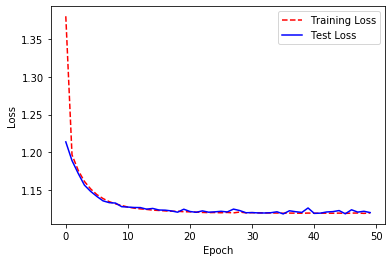

In [262]:
# Visualize loss history
plt.plot(train_loss, 'r--')
plt.plot(test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [365]:
X_latent = []
data_latent = torch.utils.data.DataLoader(torch.from_numpy(X), batch_size=batch_size, shuffle=False)
for x in tqdm(data_latent):
  x = x.float()
  x = x.to(device)
  pi = model.pi_softmax(model.pi)
  mu = model.mu
  sigma = model.sigma
  pi_x1 = model.pi_x1_softmax(model.pi_x1(x[:,0].view(-1, 1)))
  mu_x1 = model.mu_x1(x[:,0].view(-1, 1))
  sigma_x1 = model.sigma_x1(x[:,0].view(-1, 1))
  latent_x1, latent_x2 = torch.zeros(x.shape[0]).to(device), torch.zeros(x.shape[0]).to(device)
  for i in range(model.k):
    # print(pi_x1[:,i].shape, torch.distributions.Normal(mu_x1[:,i], torch.exp(sigma_x1[:,i])))
    latent_x1 += pi[0][i] * torch.distributions.Normal(mu[i], torch.exp(sigma[i])).cdf(x[:,0])
    latent_x2 += pi_x1[:,i] * torch.distributions.Normal(mu_x1[:,i], torch.exp(sigma_x1[:,i])).cdf(x[:,1])
  # print(latent_x1.shape, latent_x2.shape)
  for point in list(zip(latent_x1,latent_x2)):
    X_latent.append(point)

In [0]:
X_latent = np.array(X_latent)
X_latent_x = X_latent[:,0]
X_latent_y = X_latent[:,1]

In [364]:
y[:X_latent_x.shape[0]] == 0, y[:X_latent_x.shape[0]] == 1, y[:X_latent_x.shape[0]] == 2

(array([False, False,  True, ..., False, False,  True]),
 array([False, False, False, ...,  True,  True, False]),
 array([ True,  True, False, ..., False, False, False]))

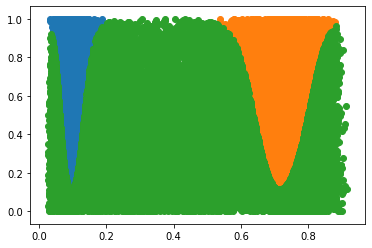

In [368]:
where = y[:X_latent_x.shape[0] + 1] == 0
plt.scatter(X_latent_x[where], X_latent_y[where])
where = y[:X_latent_x.shape[0] + 1] == 1
plt.scatter(X_latent_x[where], X_latent_y[where])
where = y[:X_latent_x.shape[0] + 1] == 2
plt.scatter(X_latent_x[where], X_latent_y[where])
plt.show()

In [0]:
latent_x1, latent_x2 = torch.zeros(x.shape), torch.zeros(x.shape)

In [296]:
latent_x1, latent_x2

(tensor([0., 0.]), tensor([0., 0.]))

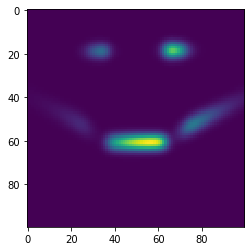

In [381]:
points = np.linspace(-4, 4, 100)
out = model(torch.tensor(np.array(np.meshgrid(points, points)).T.reshape(-1,2)).float().to(device))
plt.imshow(np.rot90(out.detach().cpu().numpy().reshape(100, 100)))
plt.show()

RealNVP

In [0]:
class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        n = 200
        a = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.ReLU(), torch.nn.Dropout())
        b = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.ReLU(), torch.nn.Dropout())
        c = torch.nn.Sequential(torch.nn.Linear(n, n), torch.Softmax(dim=1))
        self.layers = torch.nn.Sequential(a, b, c)
        
    def forward(self, x):
        return self.layers(x)

In [0]:
class Coupling(nn.Module):
  def __init__(self, do_perm):
    super().__init__()
    self.do_perm = do_perm
    self.W = MLP()
    self.b = MLP()

  def forward(self, z):
    if do_perm:
      y, x = z
    else:
      x, y = z
    a = x
    b = y * torch.exp(self.W(a)) + self.b(a)
    return a, b

In [0]:
class Actnorm(nn.Module):
  def __init__(self):
    super().__init__()
    self.W = MLP()
    self.b = MLP()

  def forward(self, z):
    return z

In [0]:
class RealNVPLike(nn.Module):
  def __init__(self, n_layers):
    super().__init__()
    self.layers = nn.ModuleList()
    for i in range(n_layers):
      self.layers.append(Coupling())
      self.layers.append(Actnorm())